# Import libraries

In [1]:
%matplotlib inline
import cv2
import json
from matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd
from PIL import Image, ImageDraw
import plotly.express as px
import shapely
from shapely import Point, Polygon
import supervision as sv
import torch
from tqdm.notebook import tqdm
from ultralytics import YOLO

ImportError: cannot import name 'Point' from 'shapely' (d:\semestr3\wzgw\wzgw_env\lib\site-packages\shapely\__init__.py)

# GPU availability check

In [2]:
HOME = os.getcwd()
print(f"{HOME = }")
print(f"{torch.cuda.is_available() = }")
print(f"{torch.cuda.device_count() = }")
device = torch.cuda.current_device()
print(f"device = {torch.cuda.current_device() = }")
print(f"{torch.cuda.device(device) = }")
print(f"{torch.cuda.get_device_name(device) = }")

HOME = 'c:\\Repos\\inz'
torch.cuda.is_available() = True
torch.cuda.device_count() = 1
device = torch.cuda.current_device() = 0
torch.cuda.device(device) = <torch.cuda.device object at 0x000001CDD0FBB0D0>
torch.cuda.get_device_name(device) = 'NVIDIA GeForce RTX 3080'


# Choose model

In [3]:
# small nano model for testing purposes 
# model = YOLO('yolov8n.pt')  # Load a pretrained YOLO model https://docs.ultralytics.com/usage/python/

# biggest yolov8 model pretrained on COCO
model = YOLO('yolov8x.pt')  # Load a pretrained YOLO model https://docs.ultralytics.com/usage/python/

In [4]:
classes = {1:'bicycle', 2:'car', 3:'motorcycle', 5:'bus', 7:'truck'}  # classes from COCO dataset

# Choose video

In [5]:
# video_path = r'C:\Repos\inz\src_vids\test_lagrange_23.mkv'
# target_path = r'C:\Repos\inz\runs\test\test_polygon_zone_lagrange_23.mkv'
# video_path = r'C:\Repos\inz\src_vids\test_hway_22.mkv'
# target_path = r'C:\Repos\inz\runs\test\test_polygon_zone_hway_22.mkv'
video_path = r'C:\Repos\inz\src_vids\test_zambrow_39.mkv'
target_path = r'C:\Repos\inz\runs\test\test_polygon_zone_zambrow_39.mkv'

In [6]:
video_info = sv.VideoInfo.from_video_path(video_path)
video_info

VideoInfo(width=1920, height=1080, fps=30, total_frames=1175)

# Draw polygon zones
1. Choose polygon corners. Add point: CTRL + LMB. Remove last point: CTRL + RMB
2. Save polygon zone (CTRL + MMB)
3. Choose zone annotation location (ALT + LMB)
4. Save zone annotation location (ALT + MMB)
5. For creating new polygon zone repeat steps 1-4
6. When done, press ESCAPE

In [7]:
def get_color(cmap="Pastel1", n_colors=9):
    """Color generator. Loops colors if end is reached.

    Args:

        cmap (str, optional): Cmap name. cmap from matplotlib.pyplot.get_cmap(cmap, n_colors). Defaults to 'Pastel1'.

        n_colors (int, optional): Number of colors. n_colors from matplotlib.pyplot.get_cmap(cmap, n_colors). Defaults to 9.

    Yields:

        list: List of r, g, b values. Eg.: (255, 255, 255)
    """
    cmap = plt.get_cmap(cmap, n_colors)
    all_colors = []
    for i in range(n_colors):
        all_colors.append([c * 255 for c in cmap(0 + (i / n_colors))])
    n = 0
    while True:
        yield all_colors[n % n_colors][:-1]
        n += 1

In [8]:
# Parameter initialization
cap = cv2.VideoCapture(video_path)
status, first_frame = cap.read()
cap.release()
good_image = first_frame.copy()
color_gen = get_color()
color = next(color_gen)
zones = dict()  # dictionary with Polygon coords
zone_annotations = dict()  # zone annotations locations
zone_colors = dict()
temp_annotation_location = None
curr_zone_id = 0

# Zone annotations text settings
tfontface = cv2.FONT_HERSHEY_SIMPLEX
tscale = 0.7
tcolor = color
tthickness = 2
tlinetype = cv2.LINE_AA

In [ ]:
# Draw polygon zones
def draw_zones(event, x, y, flags, param):
    global zones, curr_zone_id, good_image, first_frame, color, tcolor, temp_annotation_location
    # Add next point to current polygon zone
    if flags == cv2.EVENT_FLAG_CTRLKEY + cv2.EVENT_FLAG_LBUTTON:
        first_frame = good_image.copy()
        if curr_zone_id in zones:
            zones[curr_zone_id].append((x, y))
        else:
            zones[curr_zone_id] = [(x, y)]
        try:
            cv2.polylines(first_frame, np.array([zones[curr_zone_id]]), True, list(reversed(color)), 4)
        except Exception as e:
            print(e)
    # Delete last added point from current polygon zone
    elif flags == cv2.EVENT_FLAG_CTRLKEY + cv2.EVENT_FLAG_RBUTTON:
        first_frame = good_image.copy()
        try:
            zones[curr_zone_id].pop(-1)
        except IndexError:
            zones.pop(curr_zone_id, None)
        except KeyError:
            pass
        try:
            cv2.polylines(first_frame, np.array([zones[curr_zone_id]]), True, list(reversed(color)), 4)
        except Exception as e:
            print(e)
    
    # Pick annotation locations
    elif flags == cv2.EVENT_FLAG_ALTKEY + cv2.EVENT_FLAG_LBUTTON:
        first_frame = good_image.copy()
        text = f"z{curr_zone_id-1} Now: 10 Total: 1000"
        (text_width, text_height), baseline = cv2.getTextSize(text, tfontface, tscale, tthickness)
        temp_annotation_location = (x, y)
        cv2.rectangle(first_frame, (x, y), (x + text_width, y + text_height), (0,0,0), -1)
        cv2.rectangle(first_frame, (x, y), (x + text_width, y + text_height), (0,0,0), 20)
        cv2.putText(first_frame, text, (x, y+text_height), tfontface, tscale, tcolor, tthickness, tlinetype)
        
    # Save annotation location
    elif flags == cv2.EVENT_FLAG_ALTKEY + cv2.EVENT_FLAG_MBUTTON:
        good_image = first_frame
        zone_annotations[curr_zone_id-1] = temp_annotation_location

    # Save current polygon zone and move to next one
    elif flags == cv2.EVENT_FLAG_CTRLKEY + cv2.EVENT_FLAG_MBUTTON:
        good_image = first_frame
        zone_colors[curr_zone_id] = list(reversed(color))
        curr_zone_id += 1
        tcolor = list(reversed(color))
        color = next(color_gen)
    cv2.imshow("drawing polygon zones", first_frame)


cv2.namedWindow("drawing polygon zones")
cv2.setMouseCallback("drawing polygon zones", draw_zones)
while True:
    cv2.imshow("drawing polygon zones", first_frame)
    if cv2.waitKey(10) == 27:
        break
cv2.destroyAllWindows()

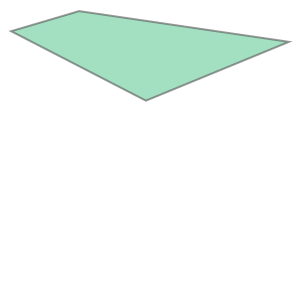

In [12]:
# Image coords different than classic math cartesian coords, but for my use-case it doesn't matter
Polygon([[xy[0], -xy[1]] for xy in zones[list(zones.keys())[0]]])
# Polygon([[xy[0], xy[1]] for xy in zones[list(zones.keys())[0]]])

# Save/Load polygon zones

In [9]:
# # Save polygon zones coords to json file
# filepath = r"C:\Repos\inz\src_json\zones_zambrow.json"
# with open(filepath, mode='w') as f:
#     f.write(json.dumps([zones, zone_annotations, zone_colors]))

In [10]:
# Load polygon zones from json file
filepath = r"C:\Repos\inz\src_json\zones_zambrow.json"
with open(filepath, mode='r') as f:
    zones, zone_annotations, zone_colors = json.loads(f.read())
zones.update({k:[tuple(xy) for xy in zones[k]] for k in zones})

In [11]:
zones, zone_annotations, zone_colors

({'0': [(459, 734), (943, 535), (233, 431), (3, 499)],
  '1': [(2, 1078), (1077, 1079), (1072, 944), (443, 778), (1, 927)],
  '2': [(1918, 1075), (1142, 938), (1511, 618), (1919, 706)],
  '3': [(1236, 521), (1553, 581), (1769, 382), (1584, 365)]},
 {'0': [98, 699], '1': [19, 808], '2': [1361, 1035], '3': [1618, 535]},
 {'0': [251.0, 180.0, 174.0],
  '1': [179.0, 205.0, 227.0],
  '2': [204.0, 235.0, 197.0],
  '3': [222.0, 203.0, 228.0]})

# Process and save whole video & Create DataFrame

In [13]:
# Model settings and initialization
results = model.track(source=video_path,
                      stream=True,  # stream=True should be used for long videos to avoid OOM errors
                      tracker='botsort.yaml',  # custombotsort.yaml
                      persist=True,
                      classes=list(classes.keys()),
                      imgsz=640,
                      conf=0.25,
                      iou=0.7,  # iou=0.7,
                      project=r'C:\Repos\inz\runs',
                      name='yolotests',
                      save=True,
                      show=False,
                      line_width=3,
                      # save_txt=True,
                      # save_conf=True,
                      # agnostic_nms=False,
                      # visualize=False,
                      # save_crop=True,
                      )

In [14]:
# Choose point location for polygon contains checks 
CHECK_MODE = 'CENTER'
CHECK_MODE = 'BOTTOM_CENTER'

# Process Whole Video and create DataFrame
video_info = sv.VideoInfo.from_video_path(video_path)
with sv.VideoSink(target_path, video_info) as s:
    temp_table = []  # list with data for df creation
    zones_objs_sets = {k:set() for k in zones.keys()}  # for each zone: unique IDs of vehicles which crossed a zone 

    for frame, r in enumerate(results):
        # detections = sv.Detections.from_yolov8(r)
        detections = sv.Detections(xyxy=r.boxes.xyxy.cpu().numpy(),
                                    confidence=r.boxes.conf.cpu().numpy(),
                                    class_id=r.boxes.cls.cpu().numpy().astype(int),
                                    tracker_id=r.boxes.id.cpu().numpy().astype(int))

        # bboxes annotation settings
        box_annotator = sv.BoxAnnotator(color=sv.ColorPalette.default(),  # sv.ColorPalette.default()
                                        thickness=2,
                                        text_color=sv.Color.black(),
                                        text_scale=0.5,
                                        text_thickness=1,
                                        text_padding=5)
        labels = [
            f"id:{tracker_id} {classes[class_id]} {confidence:0.2f}"
            for _, _, confidence, class_id, tracker_id in detections
        ]

        # frame image to draw on 
        annotated_frame = r.orig_img

        # append useful data to temp_table
        current_frame_list = []
        zone_frame_counter = [0 for _ in zones]
        for row in r.boxes.data.cpu().tolist():
            x1, y1, x2, y2, id, conf, class_no = row
            center = (round((x1+x2)/2, 2), round((y1+y2)/2, 2))
            bottom_center = (center[0], round(y2, 2))
            if CHECK_MODE == 'CENTER':
                pt_to_check = center
            elif CHECK_MODE == 'BOTTOM_CENTER':
                pt_to_check = bottom_center
            always_append_list = [int(id), int(class_no), conf, frame, x1, y1, x2, y2, center, bottom_center]

            zones_dependent_list = []
            for k, v in zones.items():
                is_in = Polygon(v).contains(Point(pt_to_check))
                zones_dependent_list.append(is_in)
                if is_in:
                    zones_objs_sets[k].add(int(id))

            current_frame_list.append(always_append_list + zones_dependent_list)
            for i, zone in enumerate(zones_dependent_list):
                if zone == True:
                    zone_frame_counter[i] += 1

        for lista in current_frame_list:
            temp_table.append(lista + zone_frame_counter + [len(zones_objs_sets[k]) for k in zones_objs_sets.keys()])  # last []: zone total counter

        # draw polygon zones on frame image
        for k, v in zones.items():
            cv2.polylines(annotated_frame, np.array([v]), isClosed=True, color=[c for c in reversed(zone_colors[k])], thickness=4)
        # fill zones with transparent color
        transparency = 77
        img = Image.fromarray(annotated_frame)
        drw = ImageDraw.Draw(img, 'RGBA')
        for k, zone in zones.items():
            drw.polygon(xy=zone, fill=(*[int(c+0.5) for c in reversed(zone_colors[k])], transparency))
        del drw
        annotated_frame = np.array(img)

        # draw zone annotations
        for i, zone_number in enumerate(zone_annotations.keys()):
            xy = zone_annotations[zone_number]
            x, y = xy[0], xy[1]
            text = f"z{zone_number} Now: {zone_frame_counter[i]} Total: {len(zones_objs_sets[zone_number])}"
            (text_width, text_height), baseline = cv2.getTextSize(text, tfontface, tscale, tthickness)
            cv2.rectangle(annotated_frame, xy, (x + text_width, y + text_height), (0,0,0), -1)
            cv2.rectangle(annotated_frame, xy, (x + text_width, y + text_height), (0,0,0), 20)
            cv2.putText(annotated_frame, text, (x, y+text_height), tfontface, tscale, [c for c in reversed(zone_colors[zone_number])], tthickness, tlinetype)
            
        # annotating bboxes
        annotated_frame = box_annotator.annotate(
            scene=annotated_frame,
            detections=detections,
            labels=labels
        )

        # write processed frame to video
        s.write_frame(annotated_frame)

# Create df
df = pd.DataFrame(temp_table, columns=['id', 'class_no', 'confidence', 'frame', 'x1', 'y1', 'x2', 'y2', 'center', 'bottom_center'] + [f'zone{k}' for k in zones.keys()] + [f'zone{k}_FC' for k in zones.keys()] + [f'zone{k}_TC' for k in zones.keys()])


video 1/1 (1/1175) C:\Repos\inz\src_vids\test_zambrow_39.mkv: 384x640 10 cars, 1 bus, 6 trucks, 83.0ms
video 1/1 (2/1175) C:\Repos\inz\src_vids\test_zambrow_39.mkv: 384x640 10 cars, 1 bus, 6 trucks, 16.0ms
video 1/1 (3/1175) C:\Repos\inz\src_vids\test_zambrow_39.mkv: 384x640 10 cars, 1 bus, 6 trucks, 17.0ms
video 1/1 (4/1175) C:\Repos\inz\src_vids\test_zambrow_39.mkv: 384x640 11 cars, 1 bus, 6 trucks, 17.0ms
video 1/1 (5/1175) C:\Repos\inz\src_vids\test_zambrow_39.mkv: 384x640 11 cars, 2 buss, 6 trucks, 15.0ms
video 1/1 (6/1175) C:\Repos\inz\src_vids\test_zambrow_39.mkv: 384x640 11 cars, 2 buss, 6 trucks, 16.0ms
video 1/1 (7/1175) C:\Repos\inz\src_vids\test_zambrow_39.mkv: 384x640 11 cars, 2 buss, 6 trucks, 16.0ms
video 1/1 (8/1175) C:\Repos\inz\src_vids\test_zambrow_39.mkv: 384x640 11 cars, 2 buss, 6 trucks, 17.0ms
video 1/1 (9/1175) C:\Repos\inz\src_vids\test_zambrow_39.mkv: 384x640 12 cars, 1 bus, 6 trucks, 16.0ms
video 1/1 (10/1175) C:\Repos\inz\src_vids\test_zambrow_39.mkv: 384x6

In [15]:
pd.options.display.max_columns = 30
pd.options.display.float_format = '{:.2f}'.format
# pd.reset_option('float_format')
df

,id,class_no,confidence,frame,x1,y1,x2,y2,center,bottom_center,zone0,zone1,zone2,zone3,zone0_FC,zone1_FC,zone2_FC,zone3_FC,zone0_TC,zone1_TC,zone2_TC,zone3_TC
0,1,7,0.94,0,251.23,686.63,896.07,1074.12,"(573.65, 880.37)","(573.65, 1074.12)",False,True,False,False,9,1,0,3,9,1,0,3
1,2,5,0.92,0,307.50,486.01,560.81,614.92,"(434.16, 550.46)","(434.16, 614.92)",True,False,False,False,9,1,0,3,9,1,0,3
2,3,2,0.87,0,957.84,652.90,1069.16,750.56,"(1013.5, 701.73)","(1013.5, 750.56)",False,False,False,False,9,1,0,3,9,1,0,3
3,4,7,0.82,0,993.67,445.99,1097.64,510.81,"(1045.66, 478.4)","(1045.66, 510.81)",False,False,False,False,9,1,0,3,9,1,0,3
4,5,2,0.78,0,263.13,553.97,346.85,615.33,"(304.99, 584.65)","(304.99, 615.33)",True,False,False,False,9,1,0,3,9,1,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19917,62,2,0.77,1174,387.79,550.74,488.03,609.40,"(437.91, 580.07)","(437.91, 609.4)",True,False,False,False,4,0,0,4,40,5,6,16
19918,71,5,0.80,1174,130.92,432.70,324.29,560.18,"(227.61, 496.44)","(227.61, 560.18)",True,False,False,False,4,0,0,4,40,5,6,16
19919,72,2,0.54,1174,39.98,465.32,73.74,505.92,"(56.86, 485.62)","(56.86, 505.92)",True,False,False,False,4,0,0,4,40,5,6,16
19920,73,2,0.85,1174,1331.66,469.29,1408.30,525.91,"(1369.98, 497.6)","(1369.98, 525.91)",False,False,False,True,4,0,0,4,40,5,6,16


# Basic detection based plots

In [12]:
unique_classes = sorted(df['class_no'].unique())
frames = {class_no:[None]*len(unique_classes) for class_no in df['frame'].unique()}
for i, class_no in enumerate(unique_classes):
    series = df[df['class_no']==class_no]['frame'].value_counts()
    for frame, count in zip(series.index, series.values):
        frames[frame][i] = count
df_class_counts = pd.DataFrame.from_dict(frames, orient='index', columns=[classes[n] for n in unique_classes])  # , dtype={c:int for c in unique_classes}
df_class_counts

NameError: name 'classes' is not defined

In [13]:
fig = px.line(df_class_counts)
fig.update_layout(title=dict(text="Number of objects detected in each frame"), xaxis_title="#frame", yaxis_title="count")
fig.show()

NameError: name 'df_class_counts' is not defined

In [39]:
fig = px.bar(df_class_counts)
fig.update_layout(title=dict(text="Number of objects detected in each frame"), xaxis_title="#frame", yaxis_title="count")
fig.show()

In [40]:
fig = px.histogram(df_class_counts, text_auto=True)
fig.update_layout(
    title=dict(text="Histogram of detections"),
    xaxis_title="#detections",
    yaxis_title="frame count",
    xaxis=dict(dtick=1),
    bargap=0.1
    )
fig.show()

In [41]:
temp_df = pd.DataFrame(df['class_no'].value_counts())
fig = px.pie(temp_df, values='count', names=[classes[i] for i in temp_df.index])
fig.update_layout(title=dict(text="Total Detections"))
fig.show()

# Polygon-zone based plots

## Zone stats

#### TEMP save/load df

In [2]:
filepath = r"D:\Repos\inz\temp\df.csv"
# Save
# df.to_csv(filepath)
# Load
df = pd.read_csv(filepath, index_col=0)

In [6]:
df

,id,class_no,confidence,frame,x1,y1,x2,y2,center,bottom_center,...,zone2,zone3,zone0_FC,zone1_FC,zone2_FC,zone3_FC,zone0_TC,zone1_TC,zone2_TC,zone3_TC
0,1,7,0.943937,0,251.225525,686.626465,896.067932,1074.116943,"(573.65, 880.37)","(573.65, 1074.12)",...,False,False,9,1,0,3,9,1,0,3
1,2,5,0.915696,0,307.504700,486.005371,560.806580,614.924316,"(434.16, 550.46)","(434.16, 614.92)",...,False,False,9,1,0,3,9,1,0,3
2,3,2,0.874476,0,957.840454,652.902954,1069.163818,750.555481,"(1013.5, 701.73)","(1013.5, 750.56)",...,False,False,9,1,0,3,9,1,0,3
3,4,7,0.822477,0,993.673950,445.994507,1097.643188,510.812653,"(1045.66, 478.4)","(1045.66, 510.81)",...,False,False,9,1,0,3,9,1,0,3
4,5,2,0.784294,0,263.126068,553.971802,346.849518,615.327637,"(304.99, 584.65)","(304.99, 615.33)",...,False,False,9,1,0,3,9,1,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19917,62,2,0.774756,1174,387.789429,550.735840,488.034851,609.400940,"(437.91, 580.07)","(437.91, 609.4)",...,False,False,4,0,0,4,40,5,6,16
19918,71,5,0.797326,1174,130.922455,432.698975,324.293671,560.180664,"(227.61, 496.44)","(227.61, 560.18)",...,False,False,4,0,0,4,40,5,6,16
19919,72,2,0.541233,1174,39.981438,465.319427,73.739586,505.924866,"(56.86, 485.62)","(56.86, 505.92)",...,False,False,4,0,0,4,40,5,6,16
19920,73,2,0.849165,1174,1331.662354,469.289764,1408.297974,525.908142,"(1369.98, 497.6)","(1369.98, 525.91)",...,False,True,4,0,0,4,40,5,6,16


In [15]:
interesting_cols = []
for name in df.columns:
    for substr in ['FC', 'TC']:
        if substr in name:
            interesting_cols.append(name)
df_zones_counts = df[['frame']+interesting_cols].groupby(['frame']).min()
df_zones_counts

,zone0_FC,zone1_FC,zone2_FC,zone3_FC,zone0_TC,zone1_TC,zone2_TC,zone3_TC
frame,,,,,,,,
0,9,1,0,3,9,1,0,3
1,9,1,0,3,9,1,0,3
2,9,1,0,3,9,1,0,3
3,9,1,0,3,9,1,0,3
4,10,1,0,3,10,1,0,3
...,...,...,...,...,...,...,...,...
1170,4,0,0,4,40,5,6,16
1171,4,0,0,4,40,5,6,16
1172,4,0,0,4,40,5,6,16


In [26]:
fig = px.line(df_zones_counts[[n for n in df_zones_counts.columns if 'FC' in n]])
fig.update_layout(title=dict(text="Vehicle count (all classes) in each frame by zone"), xaxis_title="frame", yaxis_title="count")
fig.show()

In [28]:
fig = px.line(df_zones_counts[[n for n in df_zones_counts.columns if 'TC' in n]])
fig.update_layout(title=dict(text="Vehicle total count by zone"), xaxis_title="frame", yaxis_title="count")
fig.show()

In [29]:
# dla każdej zony osobno porobić wykresy jak poprzednio

# Vehicle stats

In [ ]:
df.groupby(['frame']).tail()

In [ ]:
pd.options.display.max_rows = 70
df.groupby(['id']).tail(1)

In [ ]:
df.groupby(by=['frame']).mean()

In [ ]:
df.groupby(['frame']).mean()['zone0_TC','zone1_TC', 'zone2_TC', 'zone3_TC']